This notebook is a work in progress, a first attempt to combine the eigenvalue GPs with nu-dot measurements to find correlations. 


In [1]:
%load_ext autoreload


In [2]:
import os
import numpy as np
from scipy import stats
from astropy.timeseries import LombScargle
import astropy.units as u
from matplotlib import pyplot as plt
import cmasher as cmr
from all_prof_functions import plot_eig_gp

%aimport -os -np -plt -cmr -stats -u
%autoreload 2


In [82]:
# Set up some plotting stuff
plt.rc('savefig', bbox='tight')
#plt.rcParams['text.usetex'] = False
use_bk_bgd = False #### Change this to use white backgrounds for plots  #####
if use_bk_bgd:
    plot_style = 'dark_background'
    # The CMasher package provides lots of lovely colour maps; chroma is a handy sequential cmap
    cmap = cmr.chroma_r
    c1 = cmap(0.0)
    c2 = cmap(0.1)
    c3 = cmap(0.33)
    c4 = cmap(0.55)
    c5 = cmap(0.68)
    c6 = cmap(0.815)
    k_alpha = 0.4

else:
    plot_style = 'default'
    cmap = cmr.chroma
    c1 = cmap(0.0)
    c2 = cmap(0.3)
    c3 = cmap(0.53)
    c4 = cmap(0.65)
    c5 = cmap(0.78)
    c6 = cmap(0.915)
    k_alpha = 0.4


The following cell initialises some key variables, defining the dataset you're working on and where the data are located. Change the parameters noted below. 


In [58]:
data_dir = '/home/s86932rs/research/nudot_stuff/' # change this to the absolute/relative path to your data and .npz files
plots_dir = os.path.join(data_dir, 'plots') # change this if necessary
psr = 'B1540-06' # change to your pulsar name
freq = 1400 # change to your frequency band
be = 'afb' # change this to your backend


In [59]:
be = be.lower()
BE = be.upper()
npz_file = os.path.join(data_dir, psr+'_gps_fin.npz') # contains BE_mjds_pred, BE_res_pred, BE_vars_pred
if not os.path.exists(npz_file):
    raise(RuntimeError("File containing eigenvalue GPs does not exist"))
    
nudot_file = os.path.join(data_dir, psr+"_nudot_gp.txt") # contains columns of MJD, nudot, uncertainty
if not os.path.exists(nudot_file):
    raise(RuntimeError("File containing nu-dot GPs does not exist"))


Read in the data, selecting only the eigenvalue GPs for the relevant backend. 


In [60]:
#var_dict = {}
with np.load(npz_file, allow_pickle=True) as f_npz:
    for key in f_npz.keys():
        var_dict[key] = f_npz[key]
            
if len(var_dict) == 0:
    raise(RuntimeError("No data found for that backend"))
    
eig_mjds = var_dict[BE+'_mjds_pred'] # these MJDs were previously set using the nu-dot MJDs
eig_vals = var_dict[BE+'_res_pred']
eig_errs = var_dict[BE+'_vars_pred']


In [61]:
nudot_mjds, nudot_vals = np.loadtxt(nudot_file, unpack=True, usecols=(0, 1))
if nudot_vals.mean() > 1e7: # fix any very wrong orders of magnitude
    nudot_vals *= 1e-30
elif nudot_vals.mean() > 1e-7: # or just the appropriate order of magnitude change
    nudot_vals *= 1e-15

if min(nudot_mjds) >= max(eig_mjds) or min(eig_mjds) >= max(nudot_mjds):
    raise(RuntimeError("No overlap between timespans"))
    
nudot_errs = None


In [62]:
print("The nudot MJDs span {:.2f} to {:.2f}, and the {} profile MJDs span {:.2f} to {:.2f}".format(min(nudot_mjds), max(nudot_mjds), BE, min(eig_mjds), max(eig_mjds)))
eig_lim = np.logical_and(eig_mjds >= min(nudot_mjds)-1, eig_mjds <= max(nudot_mjds)+1)
nudot_lim = np.logical_and(nudot_mjds >= min(eig_mjds)-1, nudot_mjds <= max(eig_mjds)+1)

if len(eig_mjds[eig_lim]) != len(nudot_mjds[nudot_lim]):
    print("The maximum and minimum values of the nudot array and eigs array are {:.3f}, {:.3f}, {:.3f}, and {:.3f}, respectively"
          .format(nudot_mjds[nudot_lim].min(), nudot_mjds[nudot_lim].max(), eig_mjds[eig_lim].min(), eig_mjds[eig_lim].max()))
    print(eig_mjds[eig_lim][-2:])
    with plt.style.context(plot_style):
        #plt.plot(eig_mjds[eig_lim], color=c2)
        #plt.plot(nudot_mjds[nudot_lim], '--', color=c3)
        #gap = eig_mjds[eig_lim][-20] - eig_mjds[eig_lim][20] - 5
        plt.plot(eig_mjds[eig_lim][-20:], color=c2)
        plt.plot(nudot_mjds[nudot_lim][-20:], color=c3)
        plt.show()
    raise(RuntimeError("The trimmed MJD arrays have different lengths: {} and {}".format(len(eig_mjds[eig_lim]), len(nudot_mjds[nudot_lim]))))


The nudot MJDs span 46236.37 to 57838.49, and the AFB profile MJDs span 46236.37 to 55295.09


In [63]:
gp_corrs = np.zeros(eig_vals.shape[0])
for eignum in range(eig_vals.shape[0]):
    if eignum == 1:
        suff = 'st'
    elif eignum == 2:
        suff = 'nd'
    elif eignum == 3:
        suff = 'rd'
    else:
        suff = 'th'
    res = stats.spearmanr(eig_vals[eignum,eig_lim], nudot_vals[nudot_lim])
    gp_corrs[eignum] = res.correlation
    print("The correlation value for the {}{} eigenvector is {:.3f}".format(eignum, suff, res.correlation))


The correlation value for the 0th eigenvector is 0.143
The correlation value for the 1st eigenvector is -0.081
The correlation value for the 2nd eigenvector is 0.304
The correlation value for the 3rd eigenvector is -0.018
The correlation value for the 4th eigenvector is 0.078


In [64]:
# output the correlations in a simple format
out_file = os.path.join(data_dir, '{}_{}_{}_corrs.txt'.format(psr, be, freq))
with open(out_file, 'w') as f:
    f.write('# Component num. | Correlation value\n')
    for eignum, corr in enumerate(gp_corrs):
        f.write('{}\t\t{}\n'.format(eignum, corr))


<Figure size 640x480 with 0 Axes>

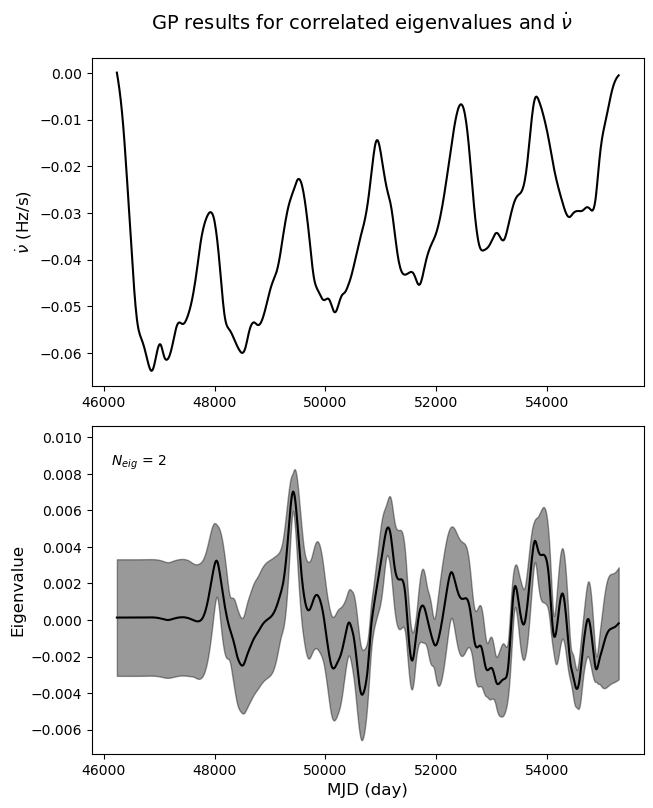

In [65]:
corr_lim = np.abs(gp_corrs) > 0.3
err_lim = np.array([np.any(eig_vals[num,:] - eig_vals[num,:].mean() > np.sqrt(eig_errs[num,:])) for num in range(eig_vals.shape[0])])
use_lim = np.logical_and(corr_lim, err_lim)

if len(gp_corrs[use_lim]) == 0:
    print("There are no significant correlated eigenvectors for {} with {} at {} MHz".format(psr, BE, freq))
else:
    nudot_vars = nudot_errs[nudot_lim]**2 if nudot_errs is not None else None
        
    plot_eig_gp(eig_mjds[eig_lim], eig_vals[:,eig_lim][use_lim,:], eig_errs[:,eig_lim][use_lim,:], bk_bgd=use_bk_bgd, show=True,
                nudot_mjds=nudot_mjds[nudot_lim], nudot_vals=nudot_vals[nudot_lim], nudot_vars=nudot_vars, eig_nums=np.arange(len(gp_corrs))[use_lim],
                savename=os.path.join(plots_dir, "{}_{}_{}_nudot_eigs_corr.png".format(psr, be, freq)))


In [66]:
var_dict['AFB_corr_lim'] = use_lim
var_dict['AFB_gp_corrs'] = gp_corrs

<Figure size 640x480 with 0 Axes>

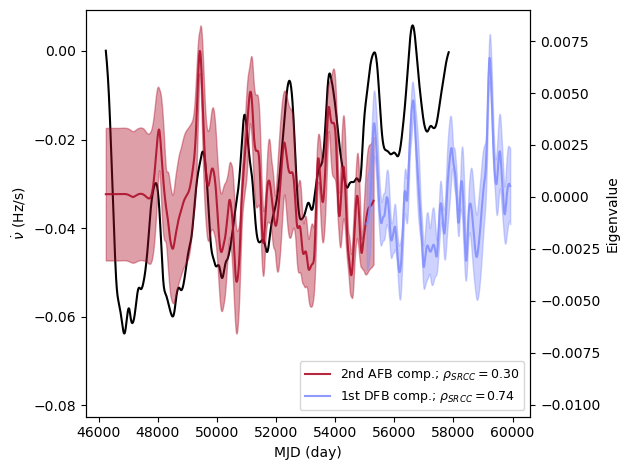

In [83]:
# make a different style of comparison plot
cmap2 = cmr.gem_r if use_bk_bgd else cmr.neon
be_list = ['afb', 'dfb']
with plt.style.context(plot_style):
    plt.clf()
    fig, ax1 = plt.subplots() # ax1 will have the nudot values
    ax2 = ax1.twinx() # ax2 will have the eigenvalues
    
    ax1.plot(nudot_mjds, nudot_vals, color=c1)
    if nudot_errs is not None:
        ax1.fill_between(nudot_mjds, nudot_vals - nudot_errs, nudot_vals + nudot_vars,
                         color=c1, alpha=k_alpha, zorder=10)
        
    ax1.set_ylabel('$\dot \\nu$ (Hz/s)')
    ax1.set_xlabel('MJD (day)')
    
    icomp_all = 0
    col_num_be_list = np.array([0.05+A*0.9/len(be_list) for A in range(len(be_list))])
    for be_num, be in enumerate(be_list):
        icomp_plot = 0
        BE = be.upper()
        comp_nums = np.arange(len(var_dict[BE+'_corr_lim']))
        col_num_be = col_num_be_list[be_num]
        col_eig_inc = 0.8*(0.9/len(be_list))/len(comp_nums[var_dict[BE+'_corr_lim']])
        for icomp_be, preds, predv in zip(comp_nums, var_dict[BE+'_res_pred'], var_dict[BE+'_vars_pred']):
            if icomp_be == 1:
                suff = 'st'
            elif icomp_be == 2:
                suff = 'nd'
            elif icomp_be == 3:
                suff = 'rd'
            else:
                suff = 'th'
                    
            # want to only plot significant correlated eigenvalues
            if var_dict[BE+'_corr_lim'][icomp_be]:
                # set the colour and alpha for the line
                col_comp = cmap2(col_num_be+icomp_plot*col_eig_inc)
                col_alpha = 0.9 - 0.1*icomp_plot
                
                ax2.plot(var_dict[BE+'_mjds_pred'], preds, color=col_comp, alpha=col_alpha,
                         label='{}{} {} comp.; $\\rho_{{SRCC}}={:.2f}$'.format(icomp_be, suff, BE, var_dict[BE+'_gp_corrs'][icomp_be]))
                ax2.fill_between(var_dict[BE+'_mjds_pred'], preds - np.sqrt(predv), preds + np.sqrt(predv),
                                 color=col_comp, alpha=k_alpha-0.1*icomp_plot)
                
                icomp_plot += 1
                
    ax2.set_ylabel('Eigenvalue')
    ylims1 = ax1.get_ylim()
    yrange1 = ylims1[1] - ylims1[0]
    ylims2 = ax2.get_ylim()
    yrange2 = ylims2[1] - ylims2[0]
    ax1.set_ylim(ylims1[1] - 1.1*yrange1, ylims1[1])
    ax2.set_ylim(ylims2[1] - 1.1*yrange2, ylims2[1])
    plt.legend(loc=4, fontsize=9)
    fig.tight_layout()
    plt.show()


Do a Lomb-Scargle analysis on the nu-dot data as well.


In [1]:
min_freq = 0.025/u.year # a period of 40 years
max_freq = 4/u.year # a period of ~90 days
nudot_errs = nudot_errs*u.Hz if nudot_errs is not None else None
LS = LombScargle(nudot_mjds*u.day, nudot_vals*u.Hz, nudot_errs)
freqs, power = LS.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=10)
freq_max_power = freqs[power == np.max(power)][0]
print("The signal-to-noise ratio (significance) of the peak found is {:.1f}".format(find_eq_width_snr(power.value)[1]))
print("The frequency of the maximum power is {:.4f} ({})".format(freq_max_power.value, freq_max_power.unit))
print("That corresponds to a period of {:.1f}".format((1/freq_max_power).to('day')))
with plt.style.context(plot_style):
    plt.clf()
    plt.plot(freqs, power, '-', color=c1)
    plt.ylabel('Periodogram Power')
    plt.xlabel('Frequency ({})'.format(freqs.unit))
    plt.xlim(min_freq.value, max_freq.value)
    plt.savefig(os.path.join(plots_dir, '{}_{}_nudot_LS.png'.format(psr, freq)), bbox_inches='tight')
    plt.show()
    

NameError: name 'u' is not defined